In [3]:
# modules import
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from metpy.interpolate import cross_section
import gsw
import cmocean

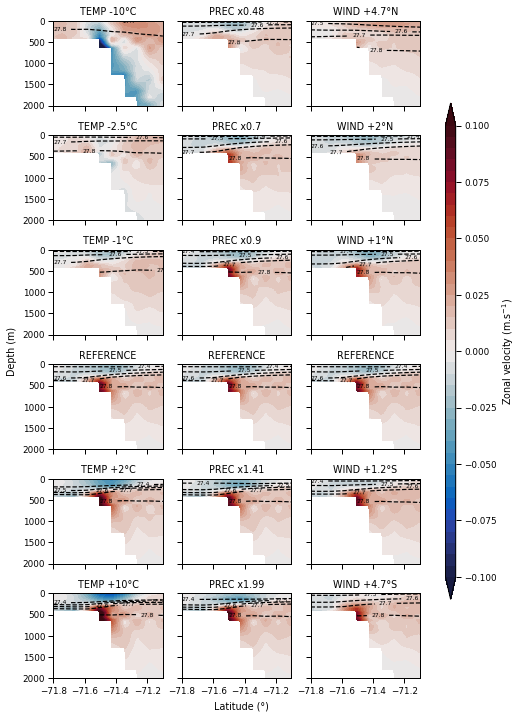

In [4]:
# cross section on longitude 115.5, latitude between -71.8 and -71.1 - zonal velocity

#files
total = ['TT', 'PT', 'WT']
general_path='/Users/jcaillet/Documents/nemo/AMUXL025/ANALYSES/NETCDF/density'

# colormap and legend
b_WIND = ['WIND +4.7°N', 'WIND +2°N', 'WIND +1°N', 'WIND +0.5°N', 'REFERENCE', 'WIND +1.2°S', 'WIND +2.4°S', 'WIND +4.7°S']
b_PREC = ['PREC x0.48', 'PREC x0.6', 'PREC x0.7', 'PREC x0.8', 'PREC x0.9', 'REFERENCE', 'PREC x1.41', 'PREC x1.99']
b_TEMP = ['TEMP -10°C', 'TEMP -5°C', 'TEMP -2.5°C', 'TEMP -1°C', 'TEMP -0.5°C', 'REFERENCE', 'TEMP +2°C', 'TEMP +5°C', 'TEMP +10°C']
cmap1 = cmocean.cm.balance

# coordonnées profil
lat1 = -71.8
lat2 = -71.1
lon1 = -115.5
lon2 = -115.5
start = (lat1, lon1)
end = (lat2, lon2)
alpha = np.arctan((lon1 - lon2) / (lat1 - lat2))

#figure
sns.set_context('paper')

f = plt.figure(figsize = (7.08, 9.85))
ax={}
nb_rows = 6
nb_cols = 3

for i in total:
    if i=='TT':
        b = np.array([0,2,3,5,6,8])
        lab = b_TEMP
        numero = 5
        k = -2
    elif i=='PT':
        b = np.array([0,2,4,5,6,7])
        lab = b_PREC
        numero = 5
        k = -1
    else :
        b = np.array([0,1,2,4,5,7])
        lab = b_WIND
        numero = 4
        k = 0
        
    netCDF_NEMO_file = f"{general_path}/density_profil_time_{i}.nc"
    DEN = xr.open_mfdataset(netCDF_NEMO_file)
    DEN['x']= DEN['x'] - DEN['x'] + DEN['lon'][0,:].values
    DEN['y']= DEN['y'] - DEN['y'] + DEN['lat'][:,0].values
    DEN01 = DEN.rename_dims({'y': 'latitude', 'x' : 'longitude'})
    DEN01 = DEN01.rename({'y': 'latitude', 'x' : 'longitude'})
    DEN01['vitu'] = DEN01['Temp'] - DEN01['Temp'] + DEN01['vitu'].values
    DEN01['vitv'] = DEN01['Temp'] - DEN01['Temp'] + DEN01['vitv'].values
    if np.tan(alpha)<0:
        DEN01['vit_ortho'] = DEN01['vitu'] * np.cos(alpha) - DEN01['vitv'] * np.sin(alpha)
    else:
        DEN01['vit_ortho'] = DEN01['vitu'] * np.cos(alpha) + DEN01['vitv'] * np.sin(alpha)
    DEN01['vit_ortho_ano'] = DEN01['vit_ortho'] - DEN01['vit_ortho'][:,:,:,numero]
    DEN01['density'] = gsw.density.sigma0(DEN01.Sal, DEN01.Temp)
    DEN01 = DEN01.where(DEN01.Sal != 0)
    DEN01 = DEN01.metpy.parse_cf().squeeze()
    
    cross1 = cross_section(DEN01, start, end).set_coords(('latitude', 'longitude'))
       
    for j in b:       
        k = k+3
        ax[k] = f.add_subplot(nb_rows,nb_cols, k)
        TOT1 = cross1.vit_ortho[:, :, j]
        TOT2 = cross1.density[:, :, j]
        # plot the zonal velocity
        c = ax[k].contourf(cross1.latitude, cross1.depth, TOT1, levels=np.arange(-0.1,0.105,0.005), cmap=cmap1, extend="both")
        # Plot the isopycnes lines
        cs = ax[k].contour(cross1.latitude, cross1.depth, TOT2, colors='black', linestyles='dashed', levels=np.arange(27.4,29.1,0.1))
        ax[k].clabel(cs, inline=1, fontsize=6)
        ax[k].set_ylim(0,2000)
        ax[k].set_title(lab[j])
        plt.gca().invert_yaxis()
        if i!='TT': 
            ax[k].axes.yaxis.set_ticklabels([])
        if k < 16:
            ax[k].axes.xaxis.set_ticklabels([])
            
plt.tight_layout()

# add label
f.text(0.45, 0.0, 'Latitude (°)', ha='center', va='center')
f.text(0.0, 0.5, 'Depth (m)', ha='center', va='center', rotation='vertical')  
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = f.colorbar(c, cax=cbar_ax)
cbar.set_label('Zonal velocity (m.s$^{-1}$)')

# saved figure
plt.savefig('/Users/jcaillet/Documents/nemo/AMUXL025/ANALYSES/RESULTS/PTAL_vitortho.pdf', bbox_inches="tight")  